In [ ]:
import dask.distributed
import pystac_client
import stackstac
import dask.array as da
from geogif import gif, dgif
import geopandas as gpd
# import hvplot.pandas to enable DataFrame.hvplot
import hvplot.pandas
from pathlib import Path
from json import loads
#Load STAC items into xarray Datasets. Process locally or distribute data loading and computation with Dask.
from odc.stac import configure_rio, load
from IPython.display import HTML, display
import folium
import folium.plugins
from branca.element import Figure
import shapely.geometry

: 

In [2]:
client = dask.distributed.Client()
display(client)

2022-10-11 13:08:43,393 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8k1kb87t', purging
2022-10-11 13:08:43,528 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-m2mr8934', purging
2022-10-11 13:08:43,529 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-gb4nquan', purging
2022-10-11 13:08:43,529 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-th9u97yf', purging
2022-10-11 13:08:43,531 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-dkmf27z1', purging
2022-10-11 13:08:43,595 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tyom_2y3', purging
2022-10-11 13:08:43,596 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-2f3qp409', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 24.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33275,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 24.77 GiB
Comm: tcp://127.0.0.1:45649,Total threads: 3
Dashboard: http://127.0.0.1:39725/status,Memory: 6.19 GiB
Nanny: tcp://127.0.0.1:37471,


In [3]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [4]:
#petermann - or create one with https://geojson.io/#map=2/20.0/0.0 and follow https://aws.amazon.com/fr/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/

#filename = "geojson file path"# read in AOI as a GeoDataFrame
filename = "petermann.geojson"# read in AOI as a GeoDataFrame
# read in AOI as a GeoDataFrame
aoi = gpd.read_file(filename)

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    aoi['geometry'],
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)


map1.fit_bounds(bounds=convert_bounds(aoi.unary_union.bounds))
display(fig)

In [5]:
# load the geometry of the AOI (GeoJSON Feature)
geom = loads(Path(filename).read_text())['geometry']

In [7]:
# STAC API Parameters
url = "https://earth-search.aws.element84.com/v0"
params = {
    "intersects": geom,
    "collections": ["sentinel-s2-l2a-cogs"],# processed and corrected version of the Sentinel-2 data in Cloud-Optimized GeoTIFF format
    "datetime": "2020-06-01/2021-06-30", #We're going to look for all data acquired over 2020
    #"query": ['sentinel:data_coverage>75']
    "query": [
        'eo:cloud_cover95'
    ]

}

With the pystac_client module’s Client class, Open the STAC API. 

In [8]:
%%time
#PySTAC Client: creates an instance by making a call to the AWS element 84 root catalog. -> https://www.element84.com/
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v0")
search = catalog.search(**params)
matched = search.matched()

if matched is not None:
    print(f"{search.matched()} scenes found")
    
# get all items
items_dict = [i.to_dict() for i in search.get_items()]

print(f"{len(items_dict)} scenes fetched")

5546 scenes found
5546 scenes fetched
CPU times: user 8.64 s, sys: 1.75 s, total: 10.4 s
Wall time: 1min 26s


In [26]:
%%time

bbox =aoi.unary_union.bounds
items = (
    pystac_client.Client.open("https://earth-search.aws.element84.com/v0")
    .search(
        bbox=bbox,
        collections=["sentinel-s2-l2a-cogs"],
        query={"eo:cloud_cover":{"lt":15},"sentinel:valid_cloud_cover": {"eq": True}},
        datetime = "2020-06-01/2020-06-15",     
        limit=100
        
    )
)

items.matched()

CPU times: user 93.6 ms, sys: 0 ns, total: 93.6 ms
Wall time: 1.1 s


72

In [27]:
items.item_collection()

ID: S2B_19XEK_20200615_2_L2A
"Bounding Box: [-69.00109527636621, 80.05764124619328, -62.69690615199551, 81.06087201458783]"
Datetime: 2020-06-15 20:20:36+00:00
created: 2020-08-19T14:06:42.976Z
sentinel:product_id: S2B_MSIL2A_20200615T201849_N0214_R071_T19XEK_20200615T225611
sentinel:sequence: 2
view:off_nadir: 0
sentinel:valid_cloud_cover: True
platform: sentinel-2b
sentinel:utm_zone: 19
proj:epsg: 32619


Turn STAC items into xarray as a temporal stack, using stackstac.


In [28]:
stack = stackstac.stack(items.item_collection(), bounds_latlon=bbox, epsg = 32620, resolution=30)


Then mask out bad (cloudy) pixels, according to the Sentinel-2 SCL Scene Classification Map, and take the temporal median of each quarter (three months) to hopefully get an okay-looking cloud-free frame representative of those three months.

In [29]:

scl = stack.sel(band=["SCL"])
# Sentinel-2 Scene Classification Map: nodata, saturated/defective, dark, cloud shadow, cloud med. prob., cloud high prob., cirrus
invalid = da.isin(scl, [0, 1, 2, 3, 8, 9, 10])
valid = stack.where(~invalid)

rgb = valid.sel(band=["B04", "B03", "B02"])

quarterly = rgb.resample(time="Q").median()
quarterly

<xarray.DataArray 'stackstac-9826490fcd8fd9435666b1f8d36351b9' (time: 1,
                                                                band: 3,
                                                                y: 2696, x: 2826)>
dask.array<stack, shape=(1, 3, 2696, 2826), dtype=float64, chunksize=(1, 1, 482, 482), chunktype=numpy.ndarray>
Coordinates:
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 4.966e+05 4.966e+05 ... 5.814e+05
  * y                           (y) float64 9.013e+06 9.013e+06 ... 8.932e+06
    view:off_nadir              int64 0
    sentinel:latitude_band      <U1 'X'
    constellation               <U10 'sentinel-2'
    instruments                 <U3 'msi'
    sentinel:valid_cloud_cover  bool True
    gsd                         int64 10
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32620
  * time                        (time) datetime64[ns] 2020-06-30
Attributes:
    spec:        RasterSpec(epsg=32620, bounds=(496620, 8932050, 581400, 9012...
    crs:         epsg:32620
    transform:   | 30.00, 0.00, 496620.00|\n| 0.00,-30.00, 9012930.00|\n| 0.0...
    resolution:  30

In [32]:
type(rgb)

xarray.core.dataarray.DataArray

/home/barreje/miniconda3/envs/geogif/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/barreje/miniconda3/envs/geogif/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/barreje/miniconda3/envs/geogif/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/barreje/miniconda3/envs/geogif/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


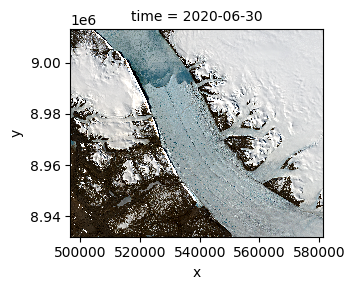

In [30]:
ts = quarterly.persist()
ts_local = ts.compute()

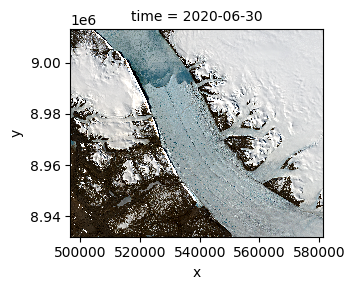

In [31]:
ts_local.plot.imshow(col="time", rgb="band", col_wrap=5, robust=True)